## Legal Effect Classification


Giacomo Grazia

Final Bachelor Project TU/e & TiU

Academic Year 2024-2025

### 1. Data for API calls

In [4]:
import pandas as pd
import re
import os

# Access the OpenAI API key from the environment variable
openai_api_key = os.getenv("OPENAI_API_KEY")

# Use the OpenAI API key
# print(f"OpenAI API Key: {openai_api_key}")

df_merged = pd.read_csv('df_merged_embeddings.csv')
df_labeled = pd.read_csv('data_giacomo_cleaned_restriced.csv', usecols=['id', 'file_number', 'decision_category'])

In [2]:
# Merge the two DataFrames on 'id' and 'file_number'
df_llm = pd.merge(
    df_merged,
    df_labeled,
    on=['id', 'file_number'],
    how='inner'  # Use 'inner' for matching rows, or 'outer' if you want all rows from both DataFrames
)

In [5]:
def remove_translations(text):
    """
    Removes text within parentheses from a string.
    """
    return re.sub(r'\s*\(.*?\)', '', text)

# Apply the function to the decision_category column
df_llm['decision_category'] = df_llm['decision_category'].apply(remove_translations)

In [6]:
df_llm = df_llm[['id', 'file_number', 'combined_text', 'text_pypdf2', 'parties_list', 'decision_category']]


In [7]:
print(df_llm.decision_category.value_counts(), '\n\n',df_llm.decision_category.value_counts(normalize=True).round(2))

decision_category
verguning verlening          146
wijziging of aanpassen       102
intrekking of beëindiging     64
none                          36
overdracht                    11
Name: count, dtype: int64 

 decision_category
verguning verlening          0.41
wijziging of aanpassen       0.28
intrekking of beëindiging    0.18
none                         0.10
overdracht                   0.03
Name: proportion, dtype: float64


In [8]:
# remove decisions without a category
df_llm = df_llm[df_llm['parties_list'] != 'Leveringsvergunningen Kleinverbruik Ex Art. 45 Gaswet']

# remove overdracht (only 11 entries)
df_llm_no_overdracht = df_llm[df_llm['decision_category'] != 'overdracht']

# same as what will be done for ML approach
df_llm_no_overdracht = df_llm_no_overdracht.drop_duplicates(subset='id', keep='first').reset_index(drop=True)

print(df_llm_no_overdracht.decision_category.value_counts(), '\n\n',df_llm_no_overdracht.decision_category.value_counts(normalize=True).round(2))

decision_category
verguning verlening          136
wijziging of aanpassen        83
intrekking of beëindiging     42
none                          18
Name: count, dtype: int64 

 decision_category
verguning verlening          0.49
wijziging of aanpassen       0.30
intrekking of beëindiging    0.15
none                         0.06
Name: proportion, dtype: float64


### 2. LLM-based classification

#### 2.1 LLM-based classification (1)

Api function with prompt 1 (categorization based on decision headline and description only).

In [9]:
from openai import OpenAI
from tqdm import tqdm
import json
# Enable the tqdm pandas integration
tqdm.pandas()

In [307]:
# Function to preprocess each row and call the OpenAI API for categorization
def categorize_with_openai(row):
    """
    Processes a row to extract headline and description, prepares a categorization prompt,
    and calls the OpenAI API to determine the appropriate category/categories.

    :param row: A row from the DataFrame containing 'headline' and 'description' (or combined_text).
    :return: list of categories assigned by the API, if any.
    """
    decision_headline_description = row.get("combined_text", "")

    prompt = f"""
    Given the following headline and description of an administrative decision, 
    categorize it into one of the following 4 categories:
    
    - "verguning verlening": decisions to grant a license
    - "wijziging of aanpassen": decisions to amend/modify a license
    - "intrekking of beëindiging": decisions to revoke/withdraw a license
    - "none": if none of the previous categories is relevant

    Guidelines for Categorization:
    1. You may assign ONLY ONE category, if applicable. 
    2. If no category is applicable, return nothing.

    Input:
    Headline and description: {decision_headline_description}

    Output Format:
    - If a category is identified, return a string in this format: "assigned_category"
    - If no category is identified, return string like this: "none"
    """
    
    # Call the OpenAI API
    try:
        response = OpenAI(api_key=openai_api_key).chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an assistant for classifying legal decisions into 4 categories."},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            # max_tokens=150,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
        
        # Extract the assistant's response
        assistant_output = response.choices[0].message.content.strip()
        # print(assistant_output)
        return json.loads(assistant_output)  # Parse JSON response from API

    except Exception as e:
        return [f"Error: {str(e)}"]  # Return error message in a list format

df_llm_no_overdracht["category_gpt_4o-mini_combined_text"] = df_llm_no_overdracht.progress_apply(categorize_with_openai, axis=1)

df_llm_no_overdracht.to_csv('df_llm_no_overdracht.csv', index=False)

  0%|          | 0/279 [00:00<?, ?it/s]

100%|██████████| 279/279 [02:57<00:00,  1.57it/s]


#### 2.2 LLM-based classification (2)

Api function with prompt 2 (categorization based on headline, description and full text).

In [315]:
# Function to preprocess each row and call the OpenAI API for categorization
def categorize_with_openai(row):
    """
    Processes a row to extract headline and description, prepares a categorization prompt,
    and calls the OpenAI API to determine the appropriate category/categories.

    :param row: A row from the DataFrame containing 'headline' and 'description' (or combined text) and the text_pydf2 column.
    :return: list of categories assigned by the API, if any.
    """
    decision_headline_description = row.get("combined_text", "")
    decision_text = row.get("text_pypdf2", "")


    prompt = f"""
    Given the following headline, description and text of an administrative decision, 
    categorize it into one of the following 4 categories:
    
    - "verguning verlening": decisions to grant a license
    - "wijziging of aanpassen": decisions to amend/modify a license
    - "intrekking of beëindiging": decisions to revoke/withdraw a license
    - "none": if none of the previous categories is relevant

    Guidelines for Categorization:
    1. You may assign ONLY ONE category, if applicable. 
    2. If no category is relevant, return nothing.

    Input:
    - Headline and description: {decision_headline_description}
    - Text: {decision_text}

    Output Format:
    - If a category is identified, return a string in this format: "assigned_category"
    - If no category is identified, return string like this: "none"
    """
    # print(prompt)

    # Call the OpenAI API
    try:
        response = OpenAI(api_key=openai_api_key).chat.completions.create(
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": "You are an assistant for classifying legal decisions into 4 categories."},
                {"role": "user", "content": prompt},
            ],
            temperature=0,
            # max_tokens=150,
            top_p=1,
            frequency_penalty=0,
            presence_penalty=0,
        )
        
        # Extract the assistant's response
        assistant_output = response.choices[0].message.content.strip()
        # print(assistant_output)
        return json.loads(assistant_output)  # Parse JSON response from API

    except Exception as e:
        return [f"Error: {str(e)}"]  # Return error message in a list format

# df_llm_no_overdracht["category_gpt_4o-mini_combined_and_full_text"] = df_llm_no_overdracht.progress_apply(categorize_with_openai, axis=1)

# df_llm_no_overdracht.to_csv('df_llm_no_overdracht.csv', index=False)

100%|██████████| 279/279 [03:53<00:00,  1.20it/s]


#### 2.3 LLM classification (1,2) evaluation

**NOTE**: reading in the following dataset bypasses the need for running the API calls again (the outputs of such calls have been stored in it).

In [10]:
df_llm_no_overdracht = pd.read_csv('df_llm_no_overdracht.csv')

In [11]:
df_llm_no_overdracht.shape

(279, 8)

In [12]:
df_llm_no_overdracht['category_gpt_4o-mini_combined_text'].value_counts()

category_gpt_4o-mini_combined_text
verguning verlening                                     171
wijziging of aanpassen                                   55
intrekking of beëindiging                                44
['Error: Expecting value: line 1 column 1 (char 0)']      8
none                                                      1
Name: count, dtype: int64

In [13]:
df_llm_no_overdracht['category_gpt_4o-mini_combined_and_full_text'].value_counts()

category_gpt_4o-mini_combined_and_full_text
verguning verlening                                     140
wijziging of aanpassen                                   86
intrekking of beëindiging                                50
['Error: Expecting value: line 1 column 1 (char 0)']      3
Name: count, dtype: int64

In [14]:
# Define the error_value as a list
error_value = ["Error: Expecting value: line 1 column 1 (char 0)"]

# Identify the indices of rows with the error value
error_rows = df_llm_no_overdracht[
    df_llm_no_overdracht['category_gpt_4o-mini_combined_text'].apply(lambda x: x == error_value) |
    df_llm_no_overdracht['category_gpt_4o-mini_combined_and_full_text'].apply(lambda x: x == error_value)
].index

# Drop the identified rows
filtered_df = df_llm_no_overdracht.drop(error_rows)

# Display the shape of the filtered DataFrame
print("Shape of the filtered DataFrame:", filtered_df.shape)

Shape of the filtered DataFrame: (279, 8)


In [15]:
filtered_df.head()

,id,file_number,combined_text,text_pypdf2,parties_list,decision_category,category_gpt_4o-mini_combined_text,category_gpt_4o-mini_combined_and_full_text
0,id_acm_energy_permit_0,1,Intrekking op eigen verzoek leveringsvergunnin...,ons kenmerk: acm/uit/606179 zaaknummer: acm/23...,['TotalEnergies Power & Gas NL'],intrekking of beëindiging,intrekking of beëindiging,intrekking of beëindiging
1,id_acm_energy_permit_1,1,Intrekking leveringsvergunningen elektriciteit...,ons kenmerk: acm/uit/617883 zaaknummer: acm/24...,['De Vrije Energie Producent B.V. Qwint B.V'],intrekking of beëindiging,intrekking of beëindiging,intrekking of beëindiging
2,id_acm_energy_permit_10,1,Vergunning elektriciteit Youfone Energie komt ...,ons kenmerk: acm/uit/618385 zaaknummer: acm/23...,NaN,wijziging of aanpassen,wijziging of aanpassen,wijziging of aanpassen
3,id_acm_energy_permit_100,1,Intrekking leveringsvergunning Energie der Ned...,acm/uit/177356 zaaknummer: acm/17/005977 beslu...,['Energie der Nederlanden'],intrekking of beëindiging,intrekking of beëindiging,intrekking of beëindiging
4,id_acm_energy_permit_101,1,Holthausen Clean Energy mag elektriciteit leve...,acm/uit/126178 muzenstraat 41 www.acm.nl 2511 ...,NaN,verguning verlening,verguning verlening,verguning verlening


##### 4.1 Evaluation LLM-based classification (1)

In [16]:
from sklearn.preprocessing import LabelEncoder

# Define columns to clean and encode
columns_to_encode = [
    'decision_category',
    'category_gpt_4o-mini_combined_text',
    'category_gpt_4o-mini_combined_and_full_text'
]

# Step 1: Combine all unique labels from relevant columns
all_labels = pd.concat([
    filtered_df['decision_category'],
    filtered_df['category_gpt_4o-mini_combined_text'],
    filtered_df['category_gpt_4o-mini_combined_and_full_text']
]).unique()

# Step 2: Fit LabelEncoder on the combined unique labels
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)

# Step 3: Transform each column using the same LabelEncoder
filtered_df['decision_category'] = label_encoder.transform(filtered_df['decision_category'])
filtered_df['category_gpt_4o-mini_combined_text'] = label_encoder.transform(filtered_df['category_gpt_4o-mini_combined_text'])
filtered_df['category_gpt_4o-mini_combined_and_full_text'] = label_encoder.transform(filtered_df['category_gpt_4o-mini_combined_and_full_text'])


--- Evaluation for headline and description ---
Classification Report:
                                                      precision    recall  f1-score   support

['Error: Expecting value: line 1 column 1 (char 0)']       0.00      0.00      0.00         0
                           intrekking of beëindiging       0.95      1.00      0.98        42
                                                none       0.00      0.00      0.00        18
                                 verguning verlening       0.79      0.99      0.88       136
                              wijziging of aanpassen       0.93      0.61      0.74        83

                                            accuracy                           0.82       279
                                           macro avg       0.53      0.52      0.52       279
                                        weighted avg       0.80      0.82      0.80       279



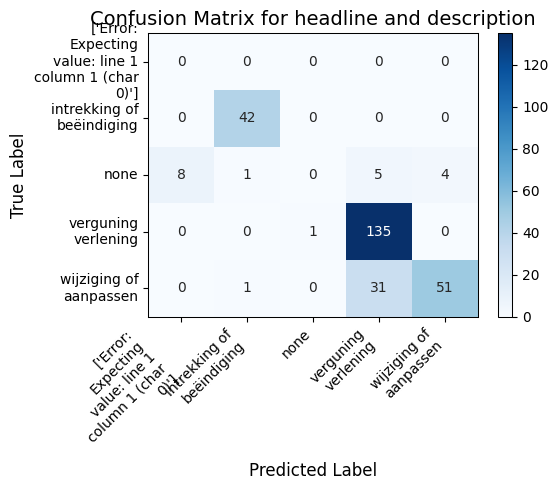


--- Evaluation for headline, description and text ---
Classification Report:
                                                      precision    recall  f1-score   support

['Error: Expecting value: line 1 column 1 (char 0)']       0.00      0.00      0.00         0
                           intrekking of beëindiging       0.84      1.00      0.91        42
                                                none       0.00      0.00      0.00        18
                                 verguning verlening       0.96      0.99      0.98       136
                              wijziging of aanpassen       0.95      0.99      0.97        83

                                            accuracy                           0.93       279
                                           macro avg       0.55      0.60      0.57       279
                                        weighted avg       0.88      0.93      0.90       279



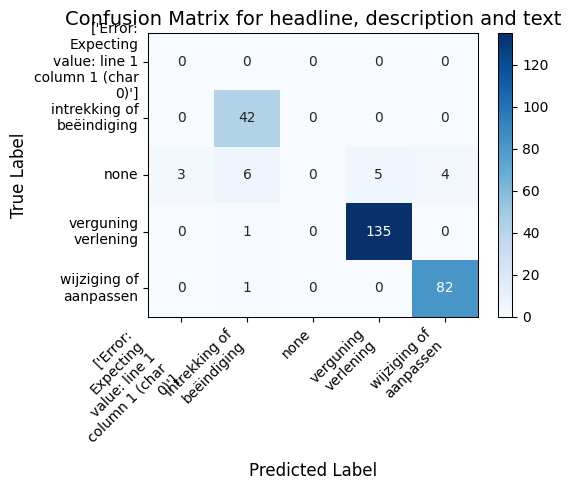

In [17]:
from sklearn.metrics import (
    accuracy_score, 
    precision_recall_fscore_support, 
    confusion_matrix, 
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns
import textwrap

# Define a function to evaluate a classifier
def evaluate_classifier(df, true_labels, pred_labels, classifier_name):
    print(f"\n--- Evaluation for {classifier_name} ---")
    
    # Accuracy
    accuracy = accuracy_score(df[true_labels], df[pred_labels])
    
    # Precision, Recall, F1 Score (weighted average across classes)
    precision, recall, f1, _ = precision_recall_fscore_support(
        df[true_labels], 
        df[pred_labels], 
        average='weighted',
        zero_division=0
    )
    
    # Classification Report
    print("Classification Report:")
    print(classification_report(df[true_labels], df[pred_labels], target_names=label_encoder.classes_, zero_division=0))
    
    # Compute the confusion matrix
    conf_matrix = confusion_matrix(df[true_labels], df[pred_labels])
    categories = label_encoder.classes_
    wrapped_labels = [textwrap.fill(label, width=14) for label in categories]

    # Plot confusion matrix heatmap
    fig, ax = plt.subplots(figsize=(5.8, 5))
    heatmap = sns.heatmap(
    conf_matrix,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=wrapped_labels,
    yticklabels=wrapped_labels,
    cbar=True,           # Enable color bar
    linewidths=0,        # Remove inner grid borders
    linecolor='white'    # Optional: inner cell borders in white
)

    # Add black border only to the heatmap's outer edges
    for _, spine in ax.spines.items():
        spine.set_visible(True)
        spine.set_color('black')
        spine.set_linewidth(0.75)

    # Add black border to the color bar
    if heatmap.collections and len(heatmap.collections) > 0:
        colorbar = heatmap.collections[0].colorbar
        colorbar.outline.set_edgecolor('black')
        colorbar.outline.set_linewidth(0.75)

    # Add titles and axis labels
    plt.title(f'Confusion Matrix for {classifier_name}', fontsize=14)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)

    # Adjust tick labels
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, ha='right', fontsize=10)  # Horizontal Y-axis labels

    # Ensure layout fits everything properly
    plt.tight_layout()
    plt.savefig(f'/Users/giacomograzia/Downloads/confusion_matrix_{classifier_name}.png', dpi=300)
    plt.show()

    
    # Return metrics
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

# Evaluate GPT-4o-mini
metrics_gpt_4o_mini = evaluate_classifier(filtered_df, 'decision_category', 'category_gpt_4o-mini_combined_text', 'headline and description')

# Evaluate GPT-4o from TEXT
metrics_gpt_4o_text = evaluate_classifier(filtered_df, 'decision_category', 'category_gpt_4o-mini_combined_and_full_text', 'headline, description and text')

# Display summary of results
# results_summary = pd.DataFrame([
#     {'Classifier': 'GPT-4o-mini from headline and description', **metrics_gpt_4o_mini},
#     {'Classifier': 'GPT-4o-mini from headline, description and text', **metrics_gpt_4o_text}
# ])
# print("\n--- Summary of Evaluation Metrics ---")
# print(results_summary)


### 3. Traditional ML approach

Visualizing stratified random sampling

In [18]:
from sklearn.model_selection import train_test_split


# Map Each ID to Its Dominant Category
id_to_category = df_llm_no_overdracht.groupby('id')['decision_category'].agg(lambda x: x.mode()[0]).reset_index()

# Stratified Split on Unique IDs Based on Dominant Category
train_ids, test_ids = train_test_split(
    id_to_category['id'], 
    test_size=0.4, 
    random_state=41, 
    stratify=id_to_category['decision_category']
)

print("Training IDs", len(train_ids))
print("Testing IDS:", len(test_ids), '\n')

# Create Train and Test DataFrames Based on Stratified IDs
df_train = df_llm_no_overdracht[df_llm_no_overdracht['id'].isin(train_ids)]
df_test = df_llm_no_overdracht[df_llm_no_overdracht['id'].isin(test_ids)]

# Verify No Data Leakage
overlapping_ids = set(df_train['id']).intersection(set(df_test['id']))
assert len(overlapping_ids) == 0, f"Data leakage detected! Overlapping IDs: {overlapping_ids}"

# Verify Class Distribution in Training and Test Sets
print("TRAIN Set Class Distribution:\n", df_train['decision_category'].value_counts(normalize=True).round(2), '\n')
print("TEST Set Class Distribution:\n", df_test['decision_category'].value_counts(normalize=True).round(2), '\n')

print("Training Set Size:", len(df_train))
print("Test Set Size:", len(df_test))


Training IDs 167
Testing IDS: 112 

TRAIN Set Class Distribution:
 decision_category
verguning verlening          0.49
wijziging of aanpassen       0.30
intrekking of beëindiging    0.15
none                         0.07
Name: proportion, dtype: float64 

TEST Set Class Distribution:
 decision_category
verguning verlening          0.49
wijziging of aanpassen       0.29
intrekking of beëindiging    0.15
none                         0.06
Name: proportion, dtype: float64 

Training Set Size: 167
Test Set Size: 112


In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import ComplementNB, MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report


# Define Classifiers
classifiers = {
    'Complement NB': ComplementNB(),
    'Multinomial NB': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=int(1e5))
}

# Define vectorizers
vectorizers = {
    # TF-IDF Vectorizers
    'TF-IDF_1-gram': TfidfVectorizer(ngram_range=(1,1)),  # unigrams only
    'TF-IDF_1,2-gram': TfidfVectorizer(ngram_range=(1,2)),  # unigrams and bigrams
    'TF-IDF_1,2,3-gram': TfidfVectorizer(ngram_range=(1,3)),  # unigrams, bigrams, trigrams
    'TF-IDF_1,2,3,4-gram': TfidfVectorizer(ngram_range=(1,4)),  # up to 4-grams
    'TF-IDF_1,2,3,4,5-gram': TfidfVectorizer(ngram_range=(1,5)),  # up to 5-grams
    'TF-IDF_2-gram': TfidfVectorizer(ngram_range=(2,2)),  # bigrams only
    'TF-IDF_3-gram': TfidfVectorizer(ngram_range=(3,3)),  # trigrams only
    'TF-IDF_4-gram': TfidfVectorizer(ngram_range=(4,4)),  # 4-grams only
    'TF-IDF_5-gram': TfidfVectorizer(ngram_range=(5,5)),  # 5-grams only

    # Binary Bag-of-Words Vectorizers
    'Binary 1-gram BoW': CountVectorizer(ngram_range=(1, 1), binary=True),  # unigrams only
    'Binary 2-gram BoW': CountVectorizer(ngram_range=(2, 2), binary=True),  # bigrams only
    'Binary 3-gram BoW': CountVectorizer(ngram_range=(3, 3), binary=True),  # trigrams only
    'Binary 4-gram BoW': CountVectorizer(ngram_range=(4, 4), binary=True),  # 4-grams only
    'Binary 5-gram BoW': CountVectorizer(ngram_range=(5, 5), binary=True),  # 5-grams only
    'Binary 1,2-gram BoW': CountVectorizer(ngram_range=(1, 2), binary=True),  # unigrams and bigrams
    'Binary 1,2,3-gram BoW': CountVectorizer(ngram_range=(1, 3), binary=True),  # up to trigrams
    'Binary 1,2,3,4-gram BoW': CountVectorizer(ngram_range=(1, 4), binary=True),  # up to 4-grams
    'Binary 1,2,3,4,5-gram BoW': CountVectorizer(ngram_range=(1, 5), binary=True),  # up to 5-grams

    # Non-Binary Bag-of-Words Vectorizers
    '1-gram BoW': CountVectorizer(ngram_range=(1, 1)),  # unigrams only
    '2-gram BoW': CountVectorizer(ngram_range=(2, 2)),  # bigrams only
    '3-gram BoW': CountVectorizer(ngram_range=(3, 3)),  # trigrams only
    '4-gram BoW': CountVectorizer(ngram_range=(4, 4)),  # 4-grams only
    '5-gram BoW': CountVectorizer(ngram_range=(5, 5)),  # 5-grams only
    '1,2-gram BoW': CountVectorizer(ngram_range=(1, 2)),  # unigrams and bigrams
    '1,2,3-gram BoW': CountVectorizer(ngram_range=(1, 3)),  # up to trigrams
    '1,2,3,4-gram BoW': CountVectorizer(ngram_range=(1, 4)),  # up to 4-grams
    '1,2,3,4,5-gram BoW': CountVectorizer(ngram_range=(1, 5))  # up to 5-grams
}

# Define a global DataFrame to collect metrics
evaluation_results = pd.DataFrame()

def evaluate_model(y_true, y_pred, classifier_name, vectorizer_name, dataset_name):
    """
    Evaluate a classifier and store metrics in a structured DataFrame.
    """
    global evaluation_results
    
    # Get accuracy and classification report
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)
    
    # Initialize row with common metadata
    row = {
        'Classifier': classifier_name,
        'Vectorizer': vectorizer_name,
        'Dataset': dataset_name,
        'Accuracy': accuracy
    }
    
    # Extract metrics for each class
    for label, metrics in report.items():
        if label == 'accuracy':  # Skip global accuracy
            continue
        
        label_key = label.replace(' ', '_')  # Handle labels with spaces
        
        row[f'Precision_{label_key}'] = metrics.get('precision', None)
        row[f'Recall_{label_key}'] = metrics.get('recall', None)
        row[f'F1_{label_key}'] = metrics.get('f1-score', None)
        row[f'Support_{label_key}'] = metrics.get('support', None)
    
    # Append row to the global DataFrame
    evaluation_results = pd.concat(
        [evaluation_results, pd.DataFrame([row])],
        ignore_index=True
    )


# Loop through text columns and evaluate each model
text_columns = ['combined_text', 'text_pypdf2']

for text_col in text_columns:
    print(f"\n### Evaluating Models Using {text_col} ###")
    
    X_train = df_train[text_col]
    y_train = df_train['decision_category']
    X_test = df_test[text_col]
    y_test = df_test['decision_category']
    
    for vec_name, vectorizer in vectorizers.items():
        # Transform text data
        X_train_vec = vectorizer.fit_transform(X_train)
        X_test_vec = vectorizer.transform(X_test)
        
        for clf_name, clf in classifiers.items():
            # Train and predict
            clf.fit(X_train_vec, y_train)
            y_pred = clf.predict(X_test_vec)
            
            # Evaluate performance
            evaluate_model(y_test, y_pred, clf_name, vec_name, text_col)



### Evaluating Models Using combined_text ###

### Evaluating Models Using text_pypdf2 ###


In [20]:
evaluation_results.sort_values('F1_macro_avg', ascending=False).head(3).round(3).T

,147,0,211
Classifier,Logistic Regression,Complement NB,Logistic Regression
Vectorizer,Binary 1-gram BoW,TF-IDF_1-gram,"1,2,3,4-gram BoW"
Dataset,text_pypdf2,combined_text,text_pypdf2
Accuracy,0.973,0.973,0.964
Precision_intrekking_of_beëindiging,1.0,0.895,1.0
Recall_intrekking_of_beëindiging,1.0,1.0,1.0
F1_intrekking_of_beëindiging,1.0,0.944,1.0
Support_intrekking_of_beëindiging,17.0,17.0,17.0
Precision_none,0.833,1.0,0.8
Recall_none,0.714,0.571,0.571


In [21]:
# print(evaluation_results.sort_values('F1_macro_avg', ascending=False).head(3).round(3).T.to_latex(float_format="%.3f", escape=True))

In [166]:
evaluation_results.sort_values('F1_weighted_avg', ascending=False).round(3).T

,171,158,182,179,178,175,174,138,170,154,...,120,116,129,125,121,112,117,109,113,108
Classifier,Logistic Regression,Random Forest,Random Forest,Logistic Regression,Random Forest,Logistic Regression,Random Forest,Random Forest,Random Forest,Random Forest,...,Complement NB,Complement NB,Multinomial NB,Multinomial NB,Multinomial NB,Complement NB,Multinomial NB,Multinomial NB,Multinomial NB,Complement NB
Vectorizer,"Binary 1,2,3-gram BoW",Binary 4-gram BoW,1-gram BoW,"Binary 1,2,3,4,5-gram BoW","Binary 1,2,3,4,5-gram BoW","Binary 1,2,3,4-gram BoW","Binary 1,2,3,4-gram BoW",TF-IDF_4-gram,"Binary 1,2,3-gram BoW",Binary 3-gram BoW,...,"TF-IDF_1,2,3,4-gram","TF-IDF_1,2,3-gram",TF-IDF_2-gram,"TF-IDF_1,2,3,4,5-gram","TF-IDF_1,2,3,4-gram","TF-IDF_1,2-gram","TF-IDF_1,2,3-gram",TF-IDF_1-gram,"TF-IDF_1,2-gram",TF-IDF_1-gram
Dataset,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,...,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2,text_pypdf2
Accuracy,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.856,0.818,0.75,0.705,0.652,0.621,0.561,0.523,0.523,0.523
Precision_intrekking_of_beëindiging,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Recall_intrekking_of_beëindiging,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.714,0.524,0.095,0.0,0.0,0.0,0.0,0.0,0.0,0.0
F1_intrekking_of_beëindiging,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.833,0.688,0.174,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Support_intrekking_of_beëindiging,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,...,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0,21.0
Precision_verguning_verlening,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.784,0.742,0.676,0.639,0.6,0.58,0.543,0.523,0.523,0.523
Recall_verguning_verlening,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [22]:
from sklearn.dummy import DummyClassifier

dummy = DummyClassifier(strategy="stratified", random_state=42)
dummy.fit(X_train_vec, y_train)
y_dummy_pred = dummy.predict(X_test_vec)

print("Dummy Classifier Report:\n", classification_report(y_test, y_dummy_pred))


Dummy Classifier Report:
                            precision    recall  f1-score   support

intrekking of beëindiging       0.14      0.18      0.16        17
                     none       0.00      0.00      0.00         7
      verguning verlening       0.46      0.44      0.45        55
   wijziging of aanpassen       0.28      0.27      0.28        33

                 accuracy                           0.32       112
                macro avg       0.22      0.22      0.22       112
             weighted avg       0.33      0.32      0.33       112



Fine tuning

In [23]:
X_train = df_train['text_pypdf2']
y_train = df_train['decision_category']
X_test = df_test['text_pypdf2']
y_test = df_test['decision_category']

print("Training Set Size:", len(X_train))
print("Test Set Size:", len(X_test))

vectorizer = CountVectorizer(ngram_range=(1, 1), binary=True)

# Transform text data
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

Training Set Size: 167
Test Set Size: 112


In [24]:
# Logistic regression (fine tuning)

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Define the parameter grid for tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],         # Regularization strength
    'solver': ['liblinear', 'saga'],      # Solver to use for optimization
    'penalty': ['l1', 'l2'],}              # Regularization penalty}

# Initialize the logistic regression model
log_reg = LogisticRegression(random_state=42, max_iter=int(1e5), 
                             class_weight=None) # {0: 0.45, 1: 0.65}

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=log_reg, 
                           param_grid=param_grid, 
                           cv=5, scoring='f1_macro', 
                           refit=True, n_jobs=-1, verbose=2)

# Fit GridSearchCV
grid_search.fit(X_train_vec, y_train)

# Get the best parameters and model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Make predictions using the best model
y_pred_best = best_model.predict(X_test_vec)
print("Tuned Model Accuracy:", accuracy_score(y_test, y_pred_best))

# Generate the classification report as a dictionary
report_dict = classification_report(y_test, y_pred_best, output_dict=True)

# Convert to DataFrame for better formatting
report_df = pd.DataFrame(report_dict).transpose()

# Round to 3 decimal places
report_df = report_df.round(3)

# Display the formatted classification report
print('\n',report_df)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ....................C=0.01, penalty=l1, solver=saga; total time=   0.0s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=   0.0s

[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   0.0s
[CV] END ...............C=0.01, penalty=l2, sol

In [25]:
print(report_df.round(2))

                           precision  recall  f1-score  support
intrekking of beëindiging       1.00    1.00      1.00    17.00
none                            0.80    0.57      0.67     7.00
verguning verlening             0.96    1.00      0.98    55.00
wijziging of aanpassen          0.97    0.97      0.97    33.00
accuracy                        0.96    0.96      0.96     0.96
macro avg                       0.93    0.88      0.90   112.00
weighted avg                    0.96    0.96      0.96   112.00


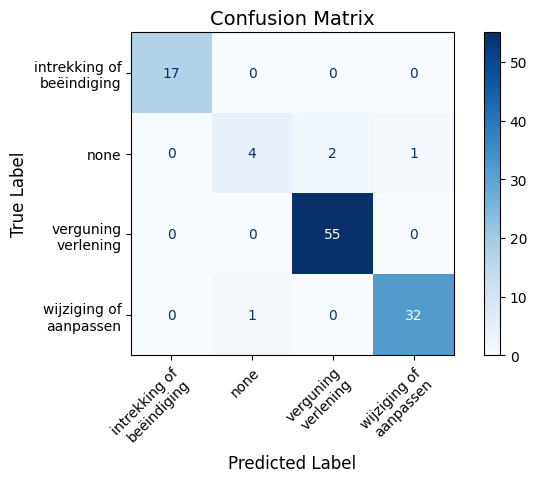

In [26]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import textwrap

# Compute the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_best, labels=best_model.classes_)

# Wrap class labels
wrapped_labels = [textwrap.fill(label, width=14) for label in best_model.classes_]

# Plot confusion matrix heatmap
fig, ax = plt.subplots(figsize=(7, 5))
disp = ConfusionMatrixDisplay(conf_matrix, display_labels=wrapped_labels)
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Confusion Matrix', fontsize=14)
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)

# Adjust spacing to prevent overlap
plt.xticks(rotation=45, ha='right', fontsize=10, wrap=True)
plt.yticks(fontsize=10, wrap=True)

# Ensure layout fits everything properly
plt.tight_layout()

# Save confusion matrix heatmap
plt.savefig('/Users/giacomograzia/Downloads/confusion_matrix_ML_heatmap.png', dpi=300)
plt.show()


In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Get class labels from your model
class_labels = best_model.classes_

# Get feature names from the vectorizer
feature_names = X_train_vec.columns if hasattr(X_train_vec, 'columns') else vectorizer.get_feature_names_out()

# Extract coefficients
coefficients = best_model.coef_

# Create a DataFrame of coefficients
coef_df = pd.DataFrame(coefficients, columns=feature_names, index=class_labels)

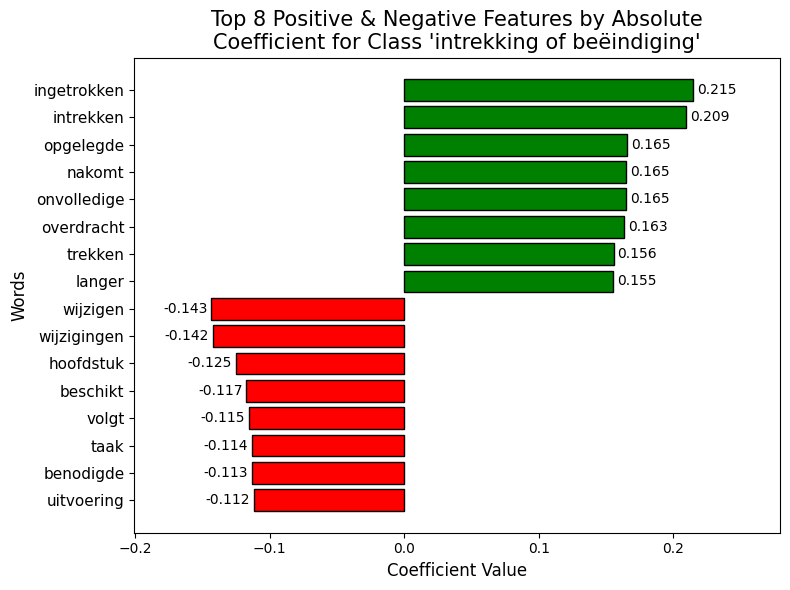

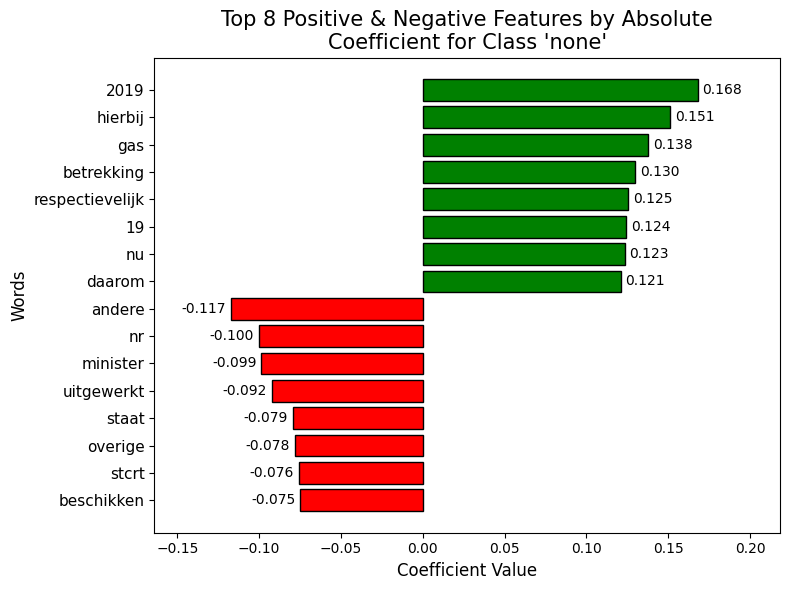

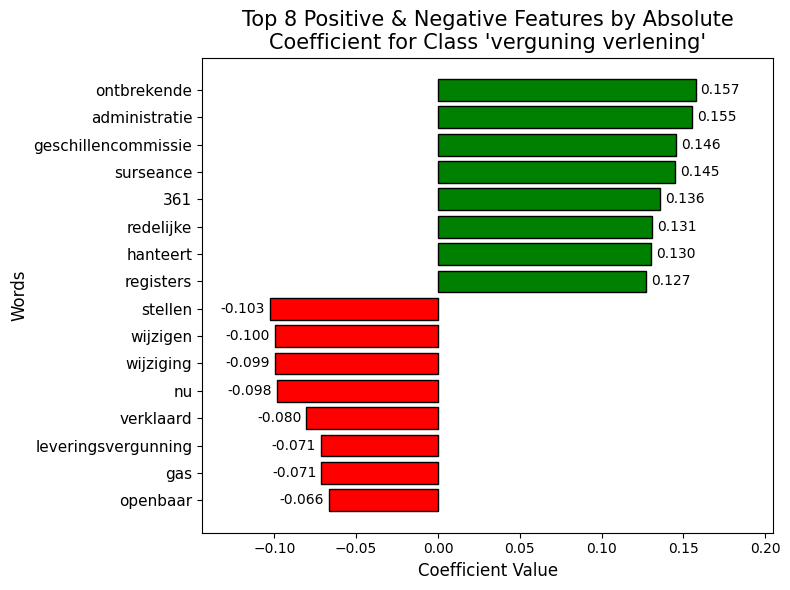

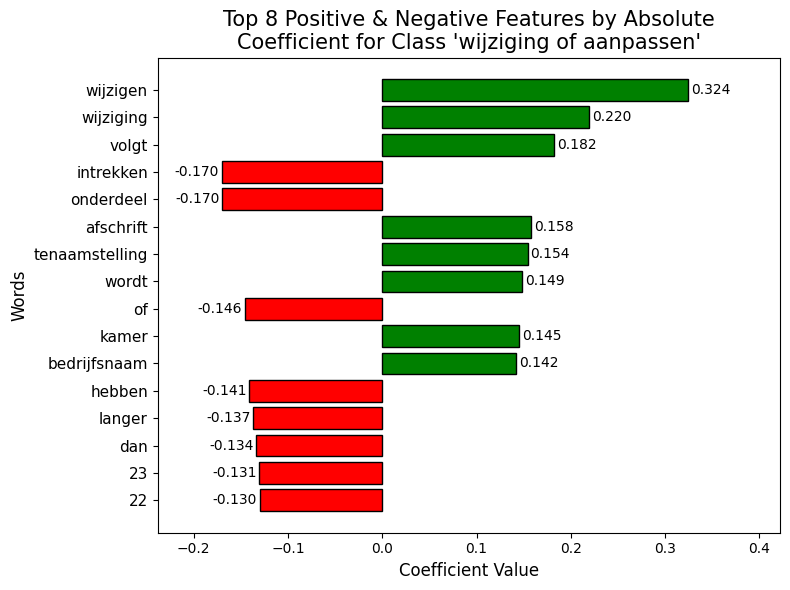

In [28]:
import matplotlib.pyplot as plt
import textwrap

def plot_top_features(class_label, coef_df, top_n=8):
    """
    Plot top N positive and top N negative coefficients by absolute value 
    for a given class, preserving sign for visualization, with black borders
    and value labels on bars. Wrapped title included.
    """
    # Get coefficients for the selected class
    class_coefficients = coef_df.loc[class_label]
    
    # Get top N positive and top N negative coefficients
    top_positive = class_coefficients[class_coefficients > 0].sort_values(ascending=False).head(top_n)
    top_negative = class_coefficients[class_coefficients < 0].sort_values(ascending=True).head(top_n)
    
    # Combine top positive and top negative
    selected_features = pd.concat([top_positive, top_negative])
    
    # Sort by absolute value for better visualization
    selected_features = selected_features.reindex(
        selected_features.abs().sort_values(ascending=False).index
    )
    
    # Plot with colors based on sign
    colors = ['red' if val < 0 else 'green' for val in selected_features]
    
    # Create plot using matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    bars = ax.barh(
        selected_features.index,
        selected_features.values,
        color=colors,
        edgecolor='black'
    )
    
    # Add value labels on top of each bar
    for bar in bars:
        x = bar.get_width()
        y = bar.get_y() + bar.get_height() / 2
        label = f"{x:.3f}"  # Format with 3 decimal places
        alignment = 'left' if x > 0 else 'right'
        offset = 0.003 if x > 0 else -0.003  # Dynamic text offset
        ax.text(
            x + offset,  # Offset for clarity
            y,
            label,
            va='center',
            ha=alignment,
            fontsize=10,
            color='black',
            clip_on=True
        )
    
    # Adjust plot limits and padding
    ax.set_xlim(left=min(selected_features.min() * 1.4, -0.01), 
                right=max(selected_features.max() * 1.3, 0.01))
    
    # Customize axis labels
    ax.set_xlabel("Coefficient Value", fontsize=12)  # X-axis label font size
    ax.set_ylabel("Words", fontsize=12)  # Y-axis label font size
    
    # Customize tick labels
    ax.tick_params(axis='x', labelsize=10)  # X-axis tick font size
    ax.tick_params(axis='y', labelsize=11)  # Y-axis tick font size 

    
    # Wrap the plot title
    wrapped_title = "\n".join(textwrap.wrap(
        f"Top {top_n} Positive & Negative Features by Absolute Coefficient for Class '{class_label}'", 
        width=50  # Adjust this width for optimal wrapping
    ))
    ax.set_title(wrapped_title, fontsize=15)
    
    ax.set_xlabel("Coefficient Value")
    ax.set_ylabel("Words")
    plt.gca().invert_yaxis()  # Invert y-axis for better readability
    
    plt.tight_layout()  # Adjust layout to prevent clipping
    plt.savefig(f'/Users/giacomograzia/Downloads/coefficients_{class_label}.png', dpi=300)
    
    plt.show()

# Plot for each class
for class_label in class_labels:
    plot_top_features(class_label, coef_df)
